In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from google.colab import drive
import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix

drive.mount('/content/drive')


path = '/content/drive/MyDrive/Nhóm 3/Bài tập trên lớp/Báo cáo tiến trình/Project/feature_extraction.csv'
df = pd.read_csv(path)
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   xeploai_tt            35849 non-null  int64  
 2   hocky                 35849 non-null  int64  
 3   namhoc                35849 non-null  int64  
 4   drltl                 35849 non-null  int64  
 5   sotchk                35849 non-null  int64  
 6   dtbhk_truoc           35849 non-null  float64
 7   xeploai               35849 non-null  int64  
 8   khuvuc_encoded        35849 non-null  int64  
 9   namnhaphoc            35849 non-null  int64  
 10  chuyennganh2_encoded  35849 non-null  float64
 11  hedt_encoded          35849 non-null  int64  
 12  khoa_encoded          35849 non-null  int64

In [ ]:
df1 = df.copy()

# Sau khi Combine

In [3]:
#Tạo các nút (node) trong đồ thị, mỗi nút đại diện cho một đặc trưng.
#Thêm cạnh (edge) giữa hai đặc trưng nếu giá trị trọng số tương ứng trong W lớn hơn 0, với trọng số của cạnh chính là giá trị từ W[i, j].

def build_initial_graph(W, feature_names):
    G = nx.Graph()
    num_features = len(feature_names)
    for i, name in enumerate(feature_names):
        G.add_node(i, label=name)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            if W[i, j] > 0:
                G.add_edge(i, j, weight=W[i, j])
    return G

# Lấy trung bình các giá trị của các đặc trưng trong cùng một cụm (cluster) để giảm chiều dữ liệu.
def average_pooling_layer(data, clusters):
    pooled_data = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_data = data.iloc[:, cluster]
        pooled_data[f"Cluster_{i+1}"] = cluster_data.mean(axis=1)
    return pooled_data

#Áp dụng phân cụm tầng bậc (hierarchical clustering) để nhóm các nút trong đồ thị thành các cụm.
def cluster_graph(G, num_clusters):
    adj_matrix = nx.to_numpy_array(G)

    clustering = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='average'
    )
    cluster_labels = clustering.fit_predict(1 - adj_matrix)
    clusters = [[] for _ in range(num_clusters)]
    for node, label in enumerate(cluster_labels):
        clusters[label].append(node)
    return clusters

#Thực hiện phân cụm và pooling qua nhiều tầng (layers).
def hierarchical_clustering_with_pooling(data, W, feature_names, num_layers, num_clusters):
    pooled_layers = [data]
    graphs = []

    G = build_initial_graph(W, feature_names)
    graphs.append(G)

    for layer in range(num_layers):
        print(f"Building Layer {layer + 1}...")
        clusters = cluster_graph(G, num_clusters)
        pooled_data = average_pooling_layer(pooled_layers[-1], clusters)
        pooled_layers.append(pooled_data)
        G = build_initial_graph(
            np.corrcoef(pooled_data.T, rowvar=True), pooled_data.columns
        )
        graphs.append(G)

    return pooled_layers, graphs


def visualize_graph(G, title="Feature Network"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=700, font_size=10, font_color='white', font_weight='bold'
    )
    edge_colors = [d['weight'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()

In [4]:
df = df[['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc', 'xeploai']]
feature_names = df.columns.drop('xeploai').tolist()

In [5]:
scaler = StandardScaler()
standardized_features = pd.DataFrame(
        scaler.fit_transform(df[feature_names]), columns=feature_names
    )

In [6]:
correlation_matrix = np.corrcoef(standardized_features.T)
np.fill_diagonal(correlation_matrix, 0)   #loại bỏ giá trị tương quan với chính nó
num_layers = 3
num_clusters = 3
pooled_layers, graphs = hierarchical_clustering_with_pooling(
  standardized_features, correlation_matrix, feature_names, num_layers, num_clusters
)

Building Layer 1...
Building Layer 2...
Building Layer 3...


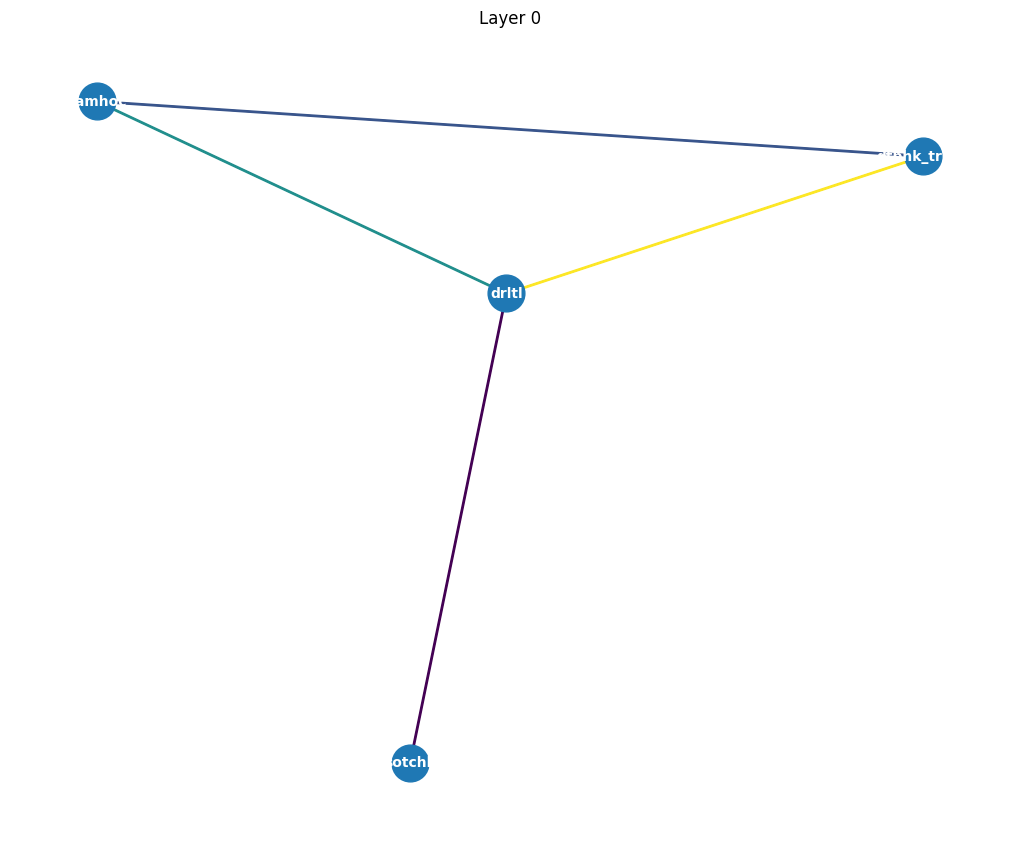

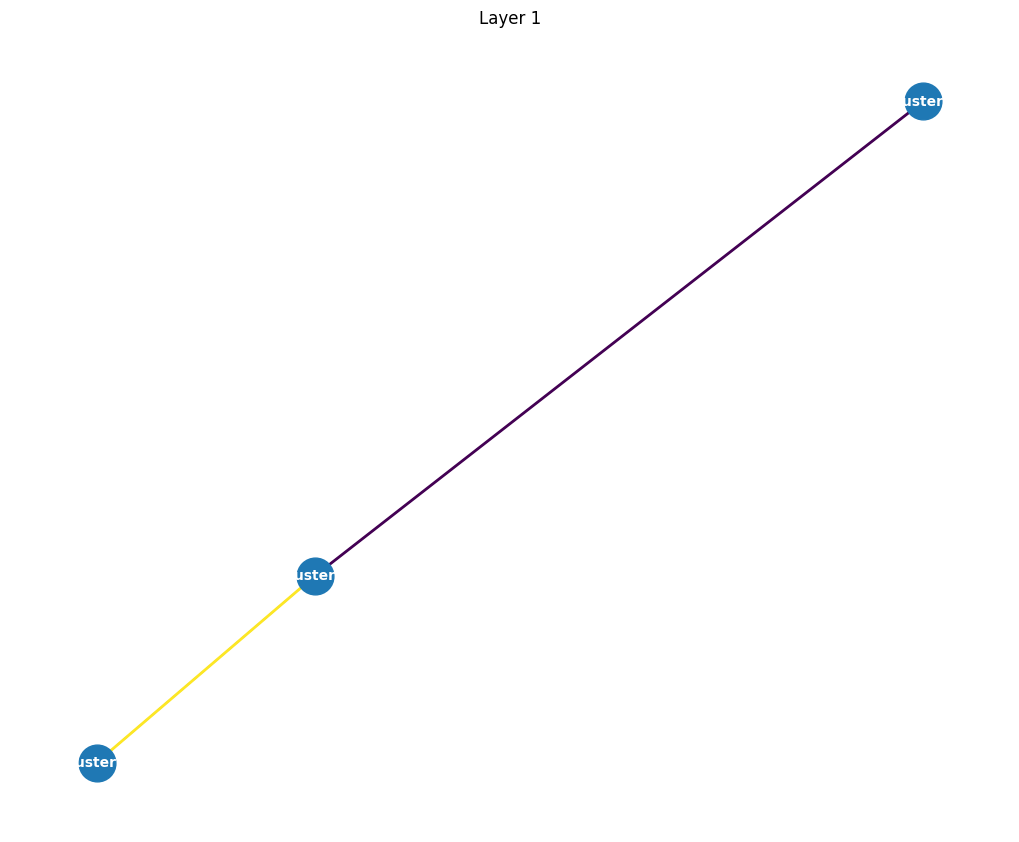

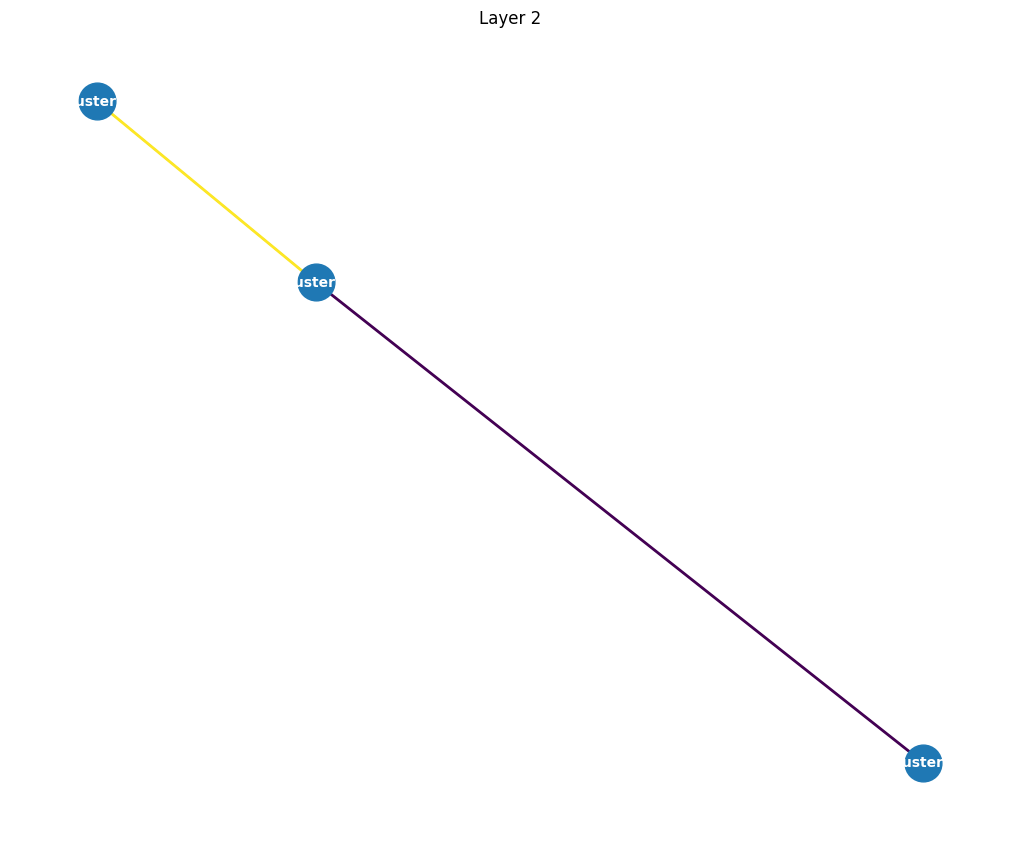

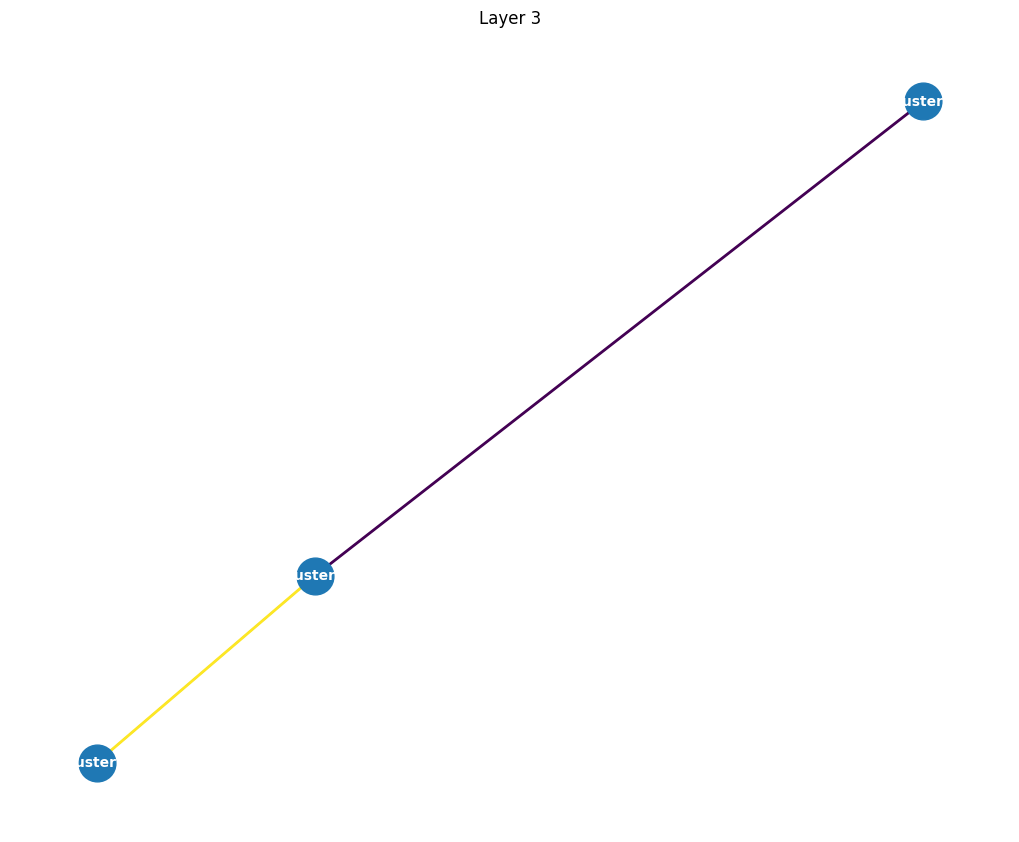

In [7]:
#Visualize
for i, G in enumerate(graphs):
        visualize_graph(G, title=f"Layer {i}")

Mỗi tầng (Layer) sau quá trình pooling sẽ trả về một tập dữ liệu mới với số đặc trưng (features) giảm dần, thể hiện qua các Cluster tương ứng.

In [8]:
#Dữ liếu sau pooling
for i, pooled_data in enumerate(pooled_layers):
  print(f"Pooled Data for Layer {i}:")
  print(pooled_data.head())

Pooled Data for Layer 0:
   dtbhk_truoc     drltl    sotchk    namhoc
0     1.065896  0.998521  0.747090  0.181935
1     1.157895  0.998521 -0.563109  0.609536
2     1.221144  0.998521  0.310357  0.609536
3     1.014147  0.998521  0.528724  1.037136
4     0.893398  0.998521  0.528724  1.037136
Pooled Data for Layer 1:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136
Pooled Data for Layer 2:
   Cluster_1  Cluster_2  Cluster_3
0   0.181935   0.747090   1.032209
1   0.609536  -0.563109   1.078208
2   0.609536   0.310357   1.109833
3   1.037136   0.528724   1.006334
4   1.037136   0.528724   0.945960
Pooled Data for Layer 3:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136


Layer 0: Dữ liệu gốc chuẩn hóa (với các đặc trưng dtbhk_truoc, drltl, sotchk, namhoc).


Layer 1: Các đặc trưng đã được gom cụm (clustering) thành 3 cụm (Cluster_1, Cluster_2, Cluster_3), mỗi cụm là giá trị trung bình của các đặc trưng gốc thuộc cùng cụm.


Layer 2 và Layer 3: Tiếp tục giảm chiều, tạo ra các giá trị cụm mới bằng cách gom cụm dựa trên các đặc trưng đã pooling từ tầng trước đó

Từng tầng thể hiện quá trình tóm tắt thông tin dần dần từ các đặc trưng ban đầu.

Ở mỗi tầng, dữ liệu được thu gọn hơn nhưng vẫn giữ được các đặc tính quan trọng thông qua trung bình các cụm.

In [9]:
X_pooled = pooled_layers[-1]  #lấy layer cuối
y = df['xeploai']

print("Original X shape:", X_pooled.shape)
print("Original y shape:", y.shape)


resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X_pooled, y)

print("Sampling X shape:", X.shape)
print("Sampling y shape:", y.shape)

Original X shape: (35849, 3)
Original y shape: (35849,)
Sampling X shape: (24496, 3)
Sampling y shape: (24496,)


In [10]:
# Define Random Forest hyperparameter grid
rf_parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=rf, param_grid=rf_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X, y)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Score: 0.9773432812194075
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [11]:
# Fit the best model
rf_best = RandomForestClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    max_depth=grid.best_params_['max_depth'],
    min_samples_split=grid.best_params_['min_samples_split'],
    min_samples_leaf=grid.best_params_['min_samples_leaf'],
    bootstrap=grid.best_params_['bootstrap'],
    random_state=42
)

# Cross-validation to calculate accuracy
scores = cross_val_score(rf_best, X, y, cv=10)
acc_rf_mean = np.mean(scores)
acc_rf_std = np.std(scores)
print(f"Mean Accuracy: {acc_rf_mean:.4f}")
print(f"Standard Deviation: {acc_rf_std:.4f}")

Mean Accuracy: 0.9804
Standard Deviation: 0.0033


# Bổ sung chia dữ liệu theo thời gian

In [ ]:
X_time = df1[(df1['hocky'] == 1)]
y_time = df1[(df1['hocky'] == 2)]
y = y_time['xeploai']
X = pd.concat([X_time.reset_index(drop=True), pd.DataFrame(X_pooled)], axis=1)
y = y_time.reset_index(drop=True)
X_train = X[X['namhoc'] < 2021]
X_test = X[X['namhoc'] >= 2021]
y_train = y[X['namhoc'] < 2021].reset_index(drop=True)['xeploai']
y_test = y[X['namhoc'] >= 2021].reset_index(drop=True)['xeploai']
X_train = X_train[['Cluster_1', 'Cluster_2', 'Cluster_3']]
X_test = X_test[['Cluster_1', 'Cluster_2', 'Cluster_3']]

In [ ]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X_train, y_train = resampler.fit_resample(X_train, y_train)

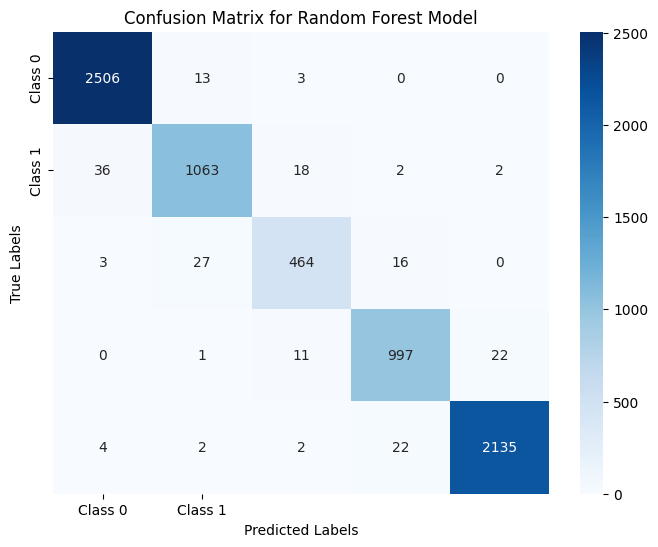

In [12]:

# Fit the model on the training data
rf_best.fit(X_train, y_train)

# Predict on the testing data
y_pred = rf_best.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [13]:
unique_classes = np.unique(y_test)
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99      2522
     Class 1       0.96      0.95      0.95      1121
     Class 2       0.93      0.91      0.92       510
     Class 3       0.96      0.97      0.96      1031
     Class 4       0.99      0.99      0.99      2165

    accuracy                           0.97      7349
   macro avg       0.97      0.96      0.96      7349
weighted avg       0.97      0.97      0.97      7349



# Trước khi combine

In [14]:
X = df.drop(['xeploai'], axis =1)
y = df['xeploai']

resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)

print("Resampled X shape:", X.shape)
print("Resampled y shape:", y.shape)

Resampled X shape: (27486, 4)
Resampled y shape: (27486,)


In [15]:
# Cross-validation scores
scores = cross_val_score(rf_best, X, y, cv=10)
acc_rf_mean = np.mean(scores)
acc_rf_std = np.std(scores)
print(f"Mean Accuracy: {acc_rf_mean:.4f}")
print(f"Standard Deviation: {acc_rf_std:.4f}")

Mean Accuracy: 0.9619
Standard Deviation: 0.0025


In [ ]:
X_time = df1[(df1['hocky'] == 1)]
y_time = df1[(df1['hocky'] == 2)]
y = y_time['xeploai']
X = pd.concat([X_time.reset_index(drop=True), pd.DataFrame(X_pooled)], axis=1)
y = y_time.reset_index(drop=True)
X_train = X[X['namhoc'] < 2021]
X_test = X[X['namhoc'] >= 2021]
y_train = y[X['namhoc'] < 2021].reset_index(drop=True)['xeploai']
y_test = y[X['namhoc'] >= 2021].reset_index(drop=True)['xeploai']
X_train = X_train[['Cluster_1', 'Cluster_2', 'Cluster_3']]
X_test = X_test[['Cluster_1', 'Cluster_2', 'Cluster_3']]

In [ ]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X_train, y_train = resampler.fit_resample(X_train, y_train)

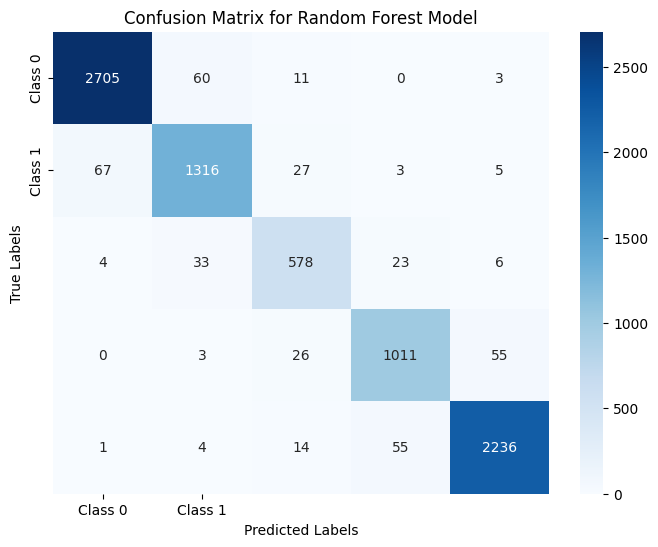

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97      2779
     Class 1       0.93      0.93      0.93      1418
     Class 2       0.88      0.90      0.89       644
     Class 3       0.93      0.92      0.92      1095
     Class 4       0.97      0.97      0.97      2310

    accuracy                           0.95      8246
   macro avg       0.94      0.94      0.94      8246
weighted avg       0.95      0.95      0.95      8246



In [16]:

# Fit the model
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Classification report
unique_classes = np.unique(y_test)
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)

# **So sánh kết quả Mean Accuracy và Standard Deviation (STD) từ 3 lần huấn luyện:**

Lần 1 (X_pooled) có Mean Accuracy cao nhất (0.9804):
Dữ liệu đã qua Pooling và giảm chiều giúp mô hình học được các đặc trưng tổng quát hơn, loại bỏ nhiễu, từ đó cải thiện độ chính xác.

Lần 2 và 3 (không qua Pooling) có Mean Accuracy thấp hơn (0.9619):
Không sử dụng kỹ thuật tóm tắt thông tin, dữ liệu có thể chứa nhiều nhiễu hơn hoặc không tối ưu về biểu diễn thông tin, dẫn đến hiệu suất kém hơn.

Lần 1 (X_pooled) có STD cao hơn chút (0.0033):
Sự biến động nhẹ này có thể xuất phát từ việc giảm chiều dữ liệu (Pooling) làm thay đổi phân phối dữ liệu, nhưng vẫn ở mức rất ổn định.

Dữ liệu gốc không qua xử lý giảm chiều, giữ nguyên phân phối ban đầu, dẫn đến độ ổn định cao hơn một chút.
